In [12]:
!pip install -Uqq pyts fastbook pandas-ta

In [13]:
# Import necessary libraries
import datetime as dt
import os
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import pywt
import pywt.data
import re
import pandas_ta as ta
from pyts.image import GramianAngularField
from PIL import Image as im
%matplotlib inline 

import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5

In [15]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [16]:
df = pd.read_csv("../input/binance-1m/binance.csv", header=0, names=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'].apply(lambda x: pd.to_datetime(x))

0        1970-01-01 00:27:41.990460
1        1970-01-01 00:27:41.990520
2        1970-01-01 00:27:41.990580
3        1970-01-01 00:27:41.990640
4        1970-01-01 00:27:41.990700
                    ...            
443053   1970-01-01 00:28:08.578440
443054   1970-01-01 00:28:08.578500
443055   1970-01-01 00:28:08.578560
443056   1970-01-01 00:28:08.578620
443057   1970-01-01 00:28:08.578680
Name: timestamp, Length: 443058, dtype: datetime64[ns]

In [17]:
df.head()

,timestamp,open,high,low,close,volume
0,1661990460000,20025.06,20038.79,20004.06,20036.92,204.52839
1,1661990520000,20036.90,20077.96,20020.22,20072.85,644.57658
2,1661990580000,20072.85,20114.85,20070.75,20112.33,338.75934
3,1661990640000,20112.34,20117.34,20082.51,20114.18,218.10600
4,1661990700000,20112.51,20123.81,20104.81,20117.29,197.82003


In [18]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label
        
       

    

In [19]:
L = len(df['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df, i)

df_labeled_raw = df.copy()
df_labeled_raw['label'] = df_labels

In [20]:
df_labeled_raw[150:300]

,timestamp,open,high,low,close,volume,label
150,1661999460000,20191.95,20193.58,20180.00,20188.65,100.82328,wait
151,1661999520000,20188.66,20199.61,20182.62,20186.45,298.65858,wait
152,1661999580000,20185.27,20189.24,20180.98,20185.54,67.22985,wait
153,1661999640000,20184.46,20187.76,20177.18,20183.98,81.85762,wait
154,1661999700000,20182.56,20190.40,20176.03,20181.18,70.25653,wait
...,...,...,...,...,...,...,...
295,1662008160000,20081.96,20084.00,20072.85,20079.95,72.24567,wait
296,1662008220000,20079.95,20081.68,20060.50,20061.32,133.73867,wait
297,1662008280000,20061.19,20067.43,20058.07,20060.79,119.38531,wait
298,1662008340000,20061.35,20064.38,20045.32,20055.59,161.26888,wait


In [21]:


df = df_labeled_raw.iloc[:-ORDER_LIFE].reset_index(drop=True).copy()

In [22]:
DS_LENGTH = len(df['close'])
df

,timestamp,open,high,low,close,volume,label
0,1661990460000,20025.06,20038.79,20004.06,20036.92,204.52839,buy
1,1661990520000,20036.90,20077.96,20020.22,20072.85,644.57658,wait
2,1661990580000,20072.85,20114.85,20070.75,20112.33,338.75934,wait
3,1661990640000,20112.34,20117.34,20082.51,20114.18,218.10600,wait
4,1661990700000,20112.51,20123.81,20104.81,20117.29,197.82003,wait
...,...,...,...,...,...,...,...
443048,1688578140000,30564.31,30581.32,30564.30,30570.13,22.76716,wait
443049,1688578200000,30570.14,30570.14,30523.78,30537.66,53.16917,wait
443050,1688578260000,30537.66,30542.56,30523.14,30523.14,29.88629,wait
443051,1688578320000,30523.15,30523.15,30506.04,30506.05,23.73126,wait


In [23]:
input_open = [None]*DS_LENGTH
input_high = [None]*DS_LENGTH
input_low = [None]*DS_LENGTH
input_close = [None]*DS_LENGTH
input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open.copy()
        input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high.copy()
        input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low.copy()
        input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close.copy()
        input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume.copy()
        input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].timestamp.copy().reset_index(drop=True)
df['input_open'] = input_open
df['input_high'] = input_high
df['input_low'] = input_low
df['input_close'] = input_close
df['input_volume'] = input_volume
df['input_timestamp'] = input_timestamp
df = df.iloc[RAW_INPUT_SIZE:].copy().reset_index(drop=True)


In [24]:
df = df[df['label'] != 'wait'].reset_index(drop=True)

In [25]:
#print(df['input_timestamp'][0])

In [26]:
DS_LENGTH = len(df['close'])
denoised_input_open = [None]*DS_LENGTH
denoised_input_high = [None]*DS_LENGTH
denoised_input_low = [None]*DS_LENGTH
denoised_input_close = [None]*DS_LENGTH
denoised_input_volume = [None]*DS_LENGTH

for i in range(0, DS_LENGTH):
    denoised_input_open[i] = denoise(df['input_open'][i])
    denoised_input_high[i] = denoise(df['input_high'][i])
    denoised_input_low[i] = denoise(df['input_low'][i])
    denoised_input_close[i] = denoise(df['input_close'][i])
    denoised_input_volume[i] = denoise(df['input_volume'][i])

df['denoised_input_open'] = denoised_input_open
df['denoised_input_high'] = denoised_input_high
df['denoised_input_low'] = denoised_input_low
df['denoised_input_close'] = denoised_input_close
df['denoised_input_volume'] = denoised_input_volume

In [27]:
print(df.ta.indicators(as_list=True))

['aberration', 'above', 'above_value', 'accbands', 'ad', 'adosc', 'adx', 'alma', 'amat', 'ao', 'aobv', 'apo', 'aroon', 'atr', 'bbands', 'below', 'below_value', 'bias', 'bop', 'brar', 'cci', 'cdl_pattern', 'cdl_z', 'cfo', 'cg', 'chop', 'cksp', 'cmf', 'cmo', 'coppock', 'cross', 'cross_value', 'cti', 'decay', 'decreasing', 'dema', 'dm', 'donchian', 'dpo', 'ebsw', 'efi', 'ema', 'entropy', 'eom', 'er', 'eri', 'fisher', 'fwma', 'ha', 'hilo', 'hl2', 'hlc3', 'hma', 'hwc', 'hwma', 'ichimoku', 'increasing', 'inertia', 'jma', 'kama', 'kc', 'kdj', 'kst', 'kurtosis', 'kvo', 'linreg', 'log_return', 'long_run', 'macd', 'mad', 'massi', 'mcgd', 'median', 'mfi', 'midpoint', 'midprice', 'mom', 'natr', 'nvi', 'obv', 'ohlc4', 'pdist', 'percent_return', 'pgo', 'ppo', 'psar', 'psl', 'pvi', 'pvo', 'pvol', 'pvr', 'pvt', 'pwma', 'qqe', 'qstick', 'quantile', 'rma', 'roc', 'rsi', 'rsx', 'rvgi', 'rvi', 'short_run', 'sinwma', 'skew', 'slope', 'sma', 'smi', 'squeeze', 'squeeze_pro', 'ssf', 'stc', 'stdev', 'stoch', '

In [28]:
ind_list = ['qstick', 't3', 'cti', 'mad', 'ha', 'squeeze', 'aroon', 'bbands', 'kc', 'vwap', 'stoch'] #df.ta.indicators(as_list=True)
#indies_partition_size = 10
#p_ind_list = [ind_list[i:i + indies_partition_size] for i in range(0, len(ind_list), indies_partition_size)]
ind_columns = ['qstick', 't3', 'cti', 'mad', 'HA_low', 'SQZ_20_2.0_20_1.5', 'AROONU_14', 'BBU_5_2.0', 'KCBe_20_2', 'vwap', 'STOCHd_14_3_3']
#p_ind_list
#exclude_indies = ['above', 'above_value', 'open', 'high', 'low', 'close', 'volume']

In [29]:
#print(df.ta.indicators(as_list=True))

In [30]:
print(ind_list)

['qstick', 't3', 'cti', 'mad', 'ha', 'squeeze', 'aroon', 'bbands', 'kc', 'vwap', 'stoch']


In [35]:
df.head()

,timestamp,open,high,low,close,volume,label,input_open,input_high,input_low,input_close,input_volume,input_timestamp,denoised_input_open,denoised_input_high,denoised_input_low,denoised_input_close,denoised_input_volume,qstick,t3,cti,mad,HA_low,SQZ_20_2.0_20_1.5,AROONU_14,BBU_5_2.0,KCBe_20_2,vwap,STOCHd_14_3_3,gaf_open,gaf_high,gaf_low,gaf_close,gaf_volume
0,1662003420000,20115.84,20124.45,20112.12,20116.46,87.07507,sell,"117 20126.77 118 20134.39 119 20127.45 120 20137.82 121 20127.24 ... 212 20138.04 213 20123.27 214 20132.34 215 20115.49 216 20115.84 Name: open, Length: 100, dtype: float64","117 20138.33 118 20135.60 119 20139.18 120 20138.60 121 20141.03 ... 212 20139.32 213 20134.47 214 20136.51 215 20122.18 216 20124.45 Name: high, Length: 100, dtype: float64","117 20122.79 118 20120.00 119 20123.54 120 20121.97 121 20124.15 ... 212 20121.93 213 20120.03 214 20111.37 215 20110.03 216 20112.12 Name: low, Length: 100, dtype: float64","117 20134.72 118 20127.45 119 20137.52 120 20125.87 121 20138.64 ... 212 20122.35 213 20131.54 214 20115.49 215 20115.84 216 20116.46 Name: close, Length: 100, dtype: float64","117 88.82194 118 88.11088 119 144.44043 120 94.39570 121 93.50431 ... 212 195.29438 213 59.56029 214 130.92635 215 82.44958 216 87.07507 Name: volume, Length: 100, dtype: float64","0 1661997480000 1 1661997540000 2 1661997600000 3 1661997660000 4 1661997720000 ... 95 1662003180000 96 1662003240000 97 1662003300000 98 1662003360000 99 1662003420000 Name: timestamp, Length: 100, dtype: int64","[20128.173572829648, 20130.714438829353, 20132.49620919205, 20132.684041672972, 20132.064713030886, 20134.557707192453, 20143.712964203416, 20153.736438654672, 20156.092283816335, 20153.38715433288, 20153.018393863815, 20154.907256506605, 20156.487375659166, 20159.221382759642, 20164.625473189248, 20172.661985680614, 20182.172689368388, 20187.477556632675, 20183.18864821064, 20173.631187987034, 20167.529089074163, 20168.591428821896, 20175.585144326542, 20181.69809625238, 20179.88027374136, 20175.630787616494, 20179.25328448132, 20188.486118659803, 20194.88150061539, 20195.240836970475, 20...","[20137.41348917868, 20137.92106086138, 20137.37843041262, 20138.036171613854, 20142.279218992524, 20149.978577545557, 20159.41787359, 20167.67965243746, 20171.83432656375, 20172.146981009526, 20171.1466480626, 20169.19107382987, 20166.596214444882, 20169.249322151158, 20181.592615051457, 20195.237211379146, 20198.596859334673, 20193.267555250084, 20187.304998722186, 20182.347921142475, 20177.80852691734, 20177.080647604944, 20181.843441163513, 20185.82811848228, 20183.370046488, 20182.134016511474, 20191.725695012457, 20203.901366941227, 20205.217515664703, 20198.61151972389, 20193.8170128...","[20122.002013757894, 20121.85188556261, 20121.74257428419, 20122.75054485249, 20125.894743062116, 20132.670217336814, 20143.116499263644, 20151.573623805165, 20152.06992052504, 20148.18459885154, 20147.342099057518, 20149.380611787852, 20151.122320434497, 20154.442217190055, 20161.467221572253, 20169.675007404097, 20175.401018994835, 20175.925308918308, 20170.476073314232, 20163.620659266053, 20161.55745108439, 20164.98001666671, 20170.482253448612, 20173.18995482482, 20170.127435195733, 20168.42266322004, 20176.908521778587, 20187.341217800233, 20186.27228315246, 20178.64738871341, 20176....","[20132.87275366102, 20132.723897350614, 20131.05650393894, 20130.90176798932, 20135.068632121085, 20143.030666394512, 20152.099291136954, 20157.559876119973, 20155.945421693865, 20151.81729642278, 20152.57405836097, 20156.90820048032, 20159.936939643616, 20163.95722846357, 20172.42788466875, 20181.80011300968, 20186.685912853573, 20184.334490177447, 20175.203522599804, 20166.870983421722, 20167.945613692176, 20175.65350843641, 20181.362307756597, 20181.4244661385, 20177.07649530288, 20176.470961432027, 20187.51490518275, 20199.2654598418, 20195.56216937401, 20185.19766444471, 20185.6675967...","[85.24156368289243, 115.68900523185329, 112.69746419675332, 96.56732

In [31]:
for indi in ind_list:
    indi_result = {}
    new_cols = []
    for i in range(0, DS_LENGTH):
        indi_input = pd.DataFrame()
        indi_input['open'] = df['denoised_input_open'][i].copy()
        indi_input['high'] = df['denoised_input_high'][i].copy()
        indi_input['low'] = df['denoised_input_low'][i].copy()
        indi_input['close'] = df['denoised_input_close'][i].copy()
        indi_input['volume'] = df['denoised_input_volume'][i].copy()
        indi_input['timestamp'] = df['input_timestamp'][i].copy(
        ).reset_index(drop=True)
        indi_input.set_index(pd.DatetimeIndex(
            indi_input["timestamp"]), inplace=True)
        indi_fn = getattr(indi_input.ta, indi)
        data = indi_fn()
        if len(new_cols) == 0:
            if not isinstance(data, pd.Series):
                new_cols = new_cols + data.columns.to_numpy().tolist()
            else:
                new_cols = new_cols + [indi]
            for col_name in new_cols:
                indi_result[col_name] = [None]*DS_LENGTH
        for col_name in new_cols:
            if not isinstance(data, pd.Series):
                indi_result[col_name][i] = data[col_name]
            else:
                indi_result[col_name][i] = data
    for col_name in new_cols:
        if col_name in ind_columns:
            df[col_name] = indi_result[col_name]


/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:52: RuntimeWarning: invalid value encountered in double_scalars
  rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  return rn / rd
/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  return rn / rd
/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:52: RuntimeWarning: invalid value encountered in double_scalars
  rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:52: RuntimeWarning: invalid value encountered in double_scalars
  rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
/opt/conda/lib/python3.10/site-packages/pandas_ta/overlap/linreg.py:53: RuntimeWarning: divide by zero encountered in double

In [32]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input_open = [None]*DS_LENGTH
df_gaf_input_high = [None]*DS_LENGTH
df_gaf_input_low = [None]*DS_LENGTH
df_gaf_input_close = [None]*DS_LENGTH
df_gaf_input_volume = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df['denoised_input_close'][i]) > 0:
        df_gaf_input_open[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_high[i] = gaf_transformer.fit_transform(df['denoised_input_high'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_low[i] = gaf_transformer.fit_transform(df['denoised_input_low'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_close[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_volume[i] = gaf_transformer.fit_transform(df['denoised_input_volume'][i][-INPUT_SIZE:].reshape(1, -1))
df['gaf_open'] = df_gaf_input_open
df['gaf_high'] = df_gaf_input_high
df['gaf_low'] = df_gaf_input_low
df['gaf_close'] = df_gaf_input_close
df['gaf_volume'] = df_gaf_input_volume


In [33]:
df = df.copy()

In [36]:
df['cti'].head()

0    timestamp
1970-01-01 00:27:41.997480         NaN
1970-01-01 00:27:41.997540         NaN
1970-01-01 00:27:41.997600         NaN
1970-01-01 00:27:41.997660         NaN
1970-01-01 00:27:41.997720         NaN
                                ...   
1970-01-01 00:27:42.003180   -0.855030
1970-01-01 00:27:42.003240   -0.848272
1970-01-01 00:27:42.003300   -0.841144
1970-01-01 00:27:42.003360   -0.834393
1970-01-01 00:27:42.003420   -0.847680
Name: CTI_12, Length: 100, dtype: float64
1    timestamp
1970-01-01 00:27:41.997540         NaN
1970-01-01 00:27:41.997600         NaN
1970-01-01 00:27:41.997660         NaN
1970-01-01 00:27:41.997720         NaN
1970-01-01 00:27:41.997780         NaN
                                ...   
1970-01-01 00:27:42.003240   -0.844565
1970-01-01 00:27:42.003300   -0.837291
1970-01-01 00:27:42.003360   -0.848582
1970-01-01 00:27:42.003420   -0.874682
1970-01-01 00:27:42.003480   -0.833978
Name: CTI_12, Length: 100, dtype: float64
2    timestamp
1970-01-01 00

qstick


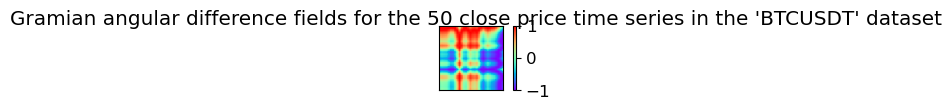

t3


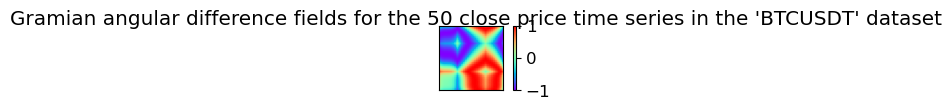

cti


ValueError: Input contains NaN.

In [34]:
for col_name in ind_columns:
    print(col_name)
    gaf_col = [None]*DS_LENGTH
    for i in range(0, DS_LENGTH):
        if len(df['denoised_input_close'][i]) > 0:
            if isinstance(df[col_name][i], pd.Series):
                gaf_col[i] = gaf_transformer.fit_transform(
                    df[col_name][i][-INPUT_SIZE:].to_numpy().reshape(1, -1))
            else:
                gaf_col[i] = gaf_transformer.fit_transform(
                    df[col_name][i][-INPUT_SIZE:].reshape(1, -1))
    df[col_name] = gaf_col
    fig = plt.figure(figsize=(1, 1))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.1, share_all=True,
                     cbar_mode='single')
    for i, ax in enumerate(grid):
        image_item = ax.imshow(df[col_name].to_numpy()[i+20].squeeze(), cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    plt.colorbar(image_item, cax=grid.cbar_axes[0])
    ax.cax.toggle_label(True)
    fig.suptitle("Gramian angular difference fields for the 50 close price time series in the "
                 "'BTCUSDT' dataset")
    plt.show()

In [ ]:
df_train = df.copy()
pat = r'^(.*)_\d+.png'
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
    os.makedirs(images_path)
files = get_image_files(images_path)
for f in files:
    os.remove(f)
files = get_image_files(images_path)
L = len(df_train['gaf_open'])
for i in range(0, L):
    i_open = df_train['gaf_open'].to_numpy()[i].squeeze()
    i_high = df_train['gaf_high'].to_numpy()[i].squeeze()
    i_low = df_train['gaf_low'].to_numpy()[i].squeeze()
    i_close = df_train['gaf_close'].to_numpy()[i].squeeze()
    i_volume = df_train['gaf_volume'].to_numpy()[i].squeeze()
    inputs_list = [i_open, i_high, i_low, i_close, i_volume] + [df_train[col_name].to_numpy()[i].squeeze() for col_name in ind_columns]
    rows_list = [inputs_list[i:i + 4] for i in range(0, len(inputs_list), 4)]
    image_rows = [np.concatenate(row) for row in rows_list]
    image = np.concatenate(image_rows, axis=1)
    label = df_train['label'].to_numpy()[i]
    matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', image)
files = get_image_files(images_path)
dls = ImageDataLoaders.from_name_re(images_path, files, pat)
#dls.show_batch()
learn = vision_learner(dls, resnet34, metrics=error_rate)

    

In [ ]:
#learn.lr_find()

In [ ]:
learn.fine_tune(20, 0.001737800776027143) #resnet34 the best so far

In [ ]:

#learn.show_results()
#learn.predict(files[0])

In [ ]:
#learn.export(fname='/kaggle/working/model.pkl')
